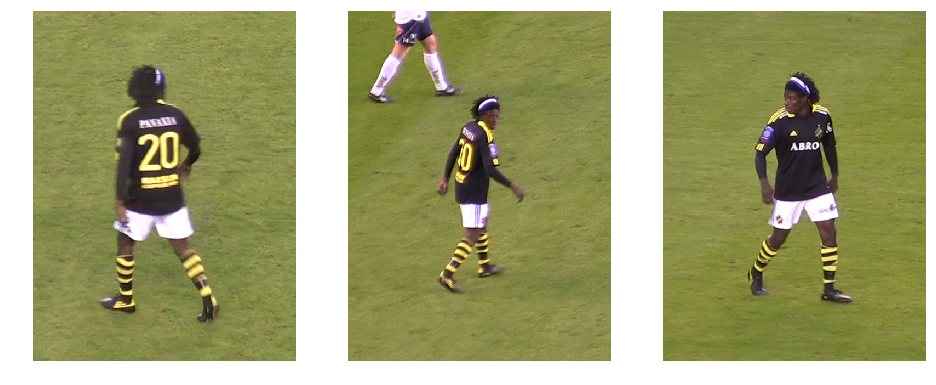

In [18]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '.')
import paf_loader
from os.path import join, isdir, isfile
from os import makedirs
import numpy as np
import cv2
from cselect import color as cs
from time import time

from pak.util.download import download
from pak.util.unzip import unzip


root = join(Settings['data_root'], 'football2')
if not isdir(root):
    makedirs(root)

def handle(seq_url, seq_dir, root, zipname):
    if not isdir(seq_dir):
        seq_zip = join(root, zipname)
        if not isfile(seq_zip):
            print("downloading ", seq_url)
            download(seq_url, seq_zip)

        print('unzipping..')
        unzip(seq_zip, root)

    
seq1_zipname = 'player1sequence1.zip'
seq1_url = 'http://www.csc.kth.se/cvap/cvg/MultiViewFootballData/player1sequence1.zip'
seq1_dir = join(root, 'Sequence 1')
handle(seq1_url, seq1_dir, root, seq1_zipname)

seq2_zipname = 'player1sequence2.zip'
seq2_url = 'http://www.csc.kth.se/cvap/cvg/MultiViewFootballData/player1sequence2.zip'
seq2_dir = join(root, 'Sequence 2')
handle(seq2_url, seq2_dir, root, seq2_zipname)

seq_dir = seq1_dir
FRAME = 1

Im = []
for cam in ['Camera 1', 'Camera 2', 'Camera 3']:
    im_dir = join(seq_dir, cam)
    assert isdir(im_dir)
    im_name = join(im_dir, "%05d.png" % FRAME)
    assert isfile(im_name)
    im = cv2.cvtColor(cv2.imread(im_name), cv2.COLOR_BGR2RGB)
    Im.append(im)
Im = np.array(Im)

fig = plt.figure(figsize=(16,8))
for i, im in enumerate(Im):
    ax = fig.add_subplot(1,3,i+1); ax.axis('off')
    ax.imshow(im)

plt.show()